### 🎧 **Spotify Collaboration Network Analysis**
A large-scale network analysis of Spotify artists based on collaboration patterns.  
We analyze 100K+ track entries to build a collaboration graph, apply graph clustering (Louvain), and train ML models to predict artist popularity from their network behavior.

**Key Technologies:** PySpark, NetworkX, ML (Sklearn), Louvain, Plotly  
**Key Outputs:** Collaboration Graph, Community Clusters, Trend Prediction, Visualizations


##Install Dependencies

In [3]:
# ✅ Install Java, Spark 3.3.2, and required Python libraries (fully tested)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark networkx matplotlib seaborn scikit-learn python-louvain

##Configure Environment and Start Spark

In [4]:
import os, sys, findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

sys.path.append("/content/spark-3.3.2-bin-hadoop3/python")
sys.path.append("/content/spark-3.3.2-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip")

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SpotifyCollabAnalysis") \
    .master("local[*]") \
    .getOrCreate()

spark.range(5).show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



##Uploading Dataset

In [5]:
from google.colab import files

# Upload your Spotify dataset (tracks.csv)
uploaded = files.upload()

Saving SpotifyFeatures.csv to SpotifyFeatures.csv


##Load and Inspect Data

In [7]:
# Load dataset into Spark DataFrame
df = spark.read.csv("SpotifyFeatures.csv", header=True, inferSchema=True)

# Preview the data
df.select("track_id", "track_name", "artist_name", "popularity", "genre").show(5)


+--------------------+--------------------+-----------------+----------+-----+
|            track_id|          track_name|      artist_name|popularity|genre|
+--------------------+--------------------+-----------------+----------+-----+
|0BRjO6ga9RKCKjfDq...|C'est beau de fai...|   Henri Salvador|         0|Movie|
|0BjC1NfoEOOusryeh...|Perdu d'avance (p...|Martin & les fées|         1|Movie|
|0CoSDzoNIKCRs124s...|Don't Let Me Be L...|  Joseph Williams|         3|Movie|
|0Gc6TVm52BwZD07Ki...|Dis-moi Monsieur ...|   Henri Salvador|         0|Movie|
|0IuslXpMROHdEPvSl...|           Ouverture|     Fabien Nataf|         4|Movie|
+--------------------+--------------------+-----------------+----------+-----+
only showing top 5 rows



In [9]:
df = spark.read.csv("SpotifyFeatures.csv", header=True, inferSchema=True)
df.columns


['genre',
 'artist_name',
 'track_name',
 'track_id',
 'popularity',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence']

##Build Artist Collaboration Graph

In [10]:
# Group artists by track
artist_tracks = df.select("track_id", "artist_name").toPandas()
track_groups = artist_tracks.groupby("track_id")["artist_name"].apply(list).reset_index()

In [11]:
# Build collaboration graph
import networkx as nx

G = nx.Graph()
for _, row in track_groups.iterrows():
    artists = row["artist_name"]
    if len(artists) > 1:
        for i in range(len(artists)):
            for j in range(i + 1, len(artists)):
                G.add_edge(artists[i], artists[j])

##Add Popularity

In [25]:
import pandas as pd

artist_pop = df.select("artist_name", "popularity").toPandas()

# Convert 'popularity' to numeric, coercing errors
artist_pop["popularity"] = pd.to_numeric(artist_pop["popularity"], errors="coerce")

# Drop rows where popularity could not be converted (if any)
artist_pop = artist_pop.dropna(subset=["popularity"])

artist_popularity = artist_pop.groupby("artist_name")["popularity"].mean().to_dict()
nx.set_node_attributes(G, artist_popularity, "popularity")

##Visualize Top Collaborators


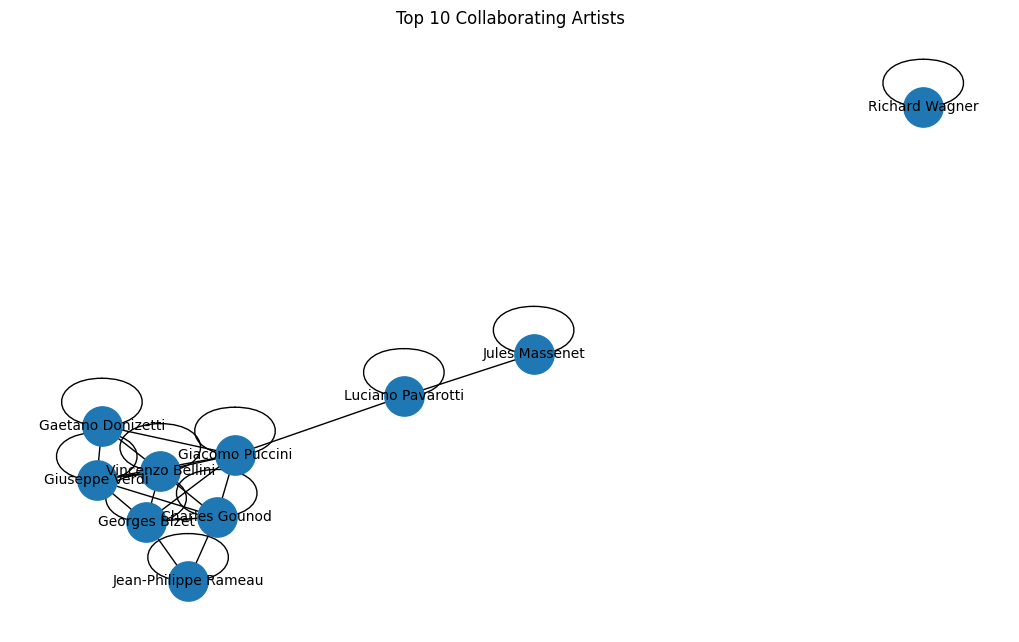

In [27]:
import matplotlib.pyplot as plt

top_10 = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]
subgraph = G.subgraph([n for n, _ in top_10])

plt.figure(figsize=(10,6))
nx.draw(subgraph, with_labels=True, node_size=800, font_size=10)
plt.title("Top 10 Collaborating Artists")
plt.show()

##Louvain Clustering

/tmp/ipython-input-2164709981.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



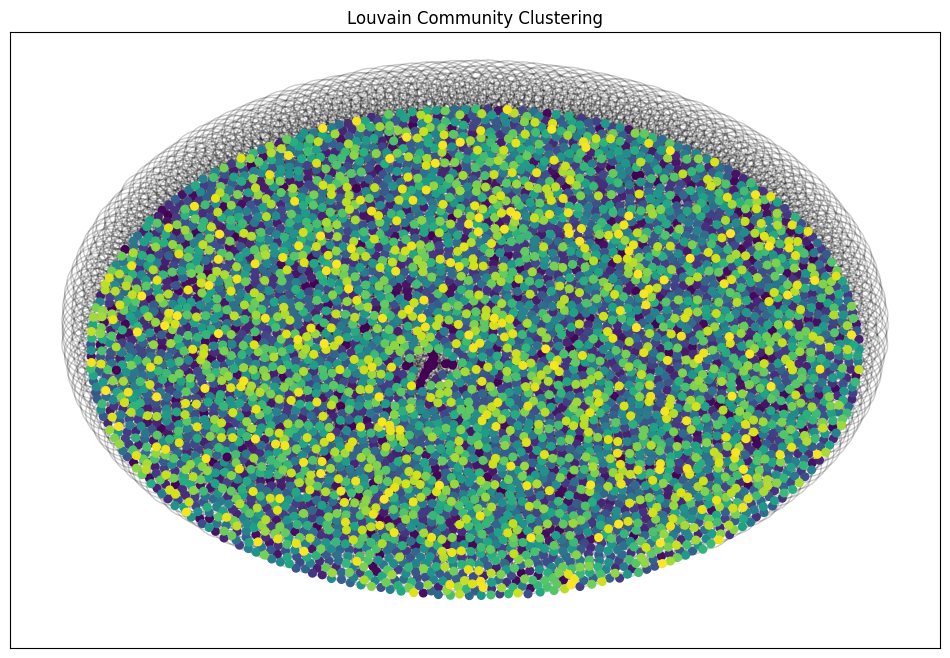

In [28]:
import community as community_louvain
import matplotlib.cm as cm

partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, "community")

# Visualize clusters
pos = nx.spring_layout(G, seed=42)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color=list(partition.values()), cmap=cmap, node_size=30)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Louvain Community Clustering")
plt.show()

##Feature Engineering for ML

In [29]:
features = []
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    num_collabs = len(neighbors)
    avg_neighbor_pop = sum([G.nodes[n].get("popularity", 0) for n in neighbors]) / (num_collabs or 1)
    own_pop = G.nodes[node].get("popularity", 0)

    features.append({
        "artist": node,
        "num_collaborations": num_collabs,
        "avg_neighbor_popularity": avg_neighbor_pop,
        "popularity": own_pop
    })

import pandas as pd
df_features = pd.DataFrame(features)
df_features.to_csv("features.csv", index=False)
df_features.head()

,artist,num_collaborations,avg_neighbor_popularity,popularity
0,Giuseppe Verdi,8,13.134808,13.313677
1,Gaetano Donizetti,4,12.935911,9.882883
2,Giacomo Puccini,8,15.563572,14.850361
3,Charles Gounod,6,14.157478,11.006993
4,Georges Bizet,6,14.157478,14.802469


from matplotlib import pyplot as plt
_df_24['num_collaborations'].plot(kind='hist', bins=20, title='num_collaborations')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25['avg_neighbor_popularity'].plot(kind='hist', bins=20, title='avg_neighbor_popularity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_26['popularity'].plot(kind='hist', bins=20, title='popularity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_27.groupby('artist').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_28.plot(kind='scatter', x='num_collaborations', y='avg_neighbor_popularity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_29.plot(kind='scatter', x='avg_neighbor_popularity', y='popularity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_30['num_collaborations'].plot(kind='line', figsize=(8, 4), title='num_collaborations')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['avg_neighbor_popularity'].plot(kind='line', figsize=(8, 4), title='avg_neighbor_popularity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_32['popularity'].plot(kind='line', figsize=(8, 4), title='popularity')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_33['artist'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_33, x='num_collaborations', y='artist', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_34['artist'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_34, x='avg_neighbor_popularity', y='artist', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_35['artist'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_35, x='popularity', y='artist', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

##ML Model to Predict Artist Popularity

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df_features[["num_collaborations", "avg_neighbor_popularity"]]
y = df_features["popularity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)

print("✅ Model trained")
print("📉 MSE:", mse)
print("📊 Coefficients:", model.coef_)

✅ Model trained
📉 MSE: 0.2899326577433939
📊 Coefficients: [-0.05033935  1.00431838]


## lets Enhance ML with More Features

In [31]:
# Merge genre from original data
artist_genre = df.select("artist_name", "genre").toPandas()
artist_genre = artist_genre.dropna(subset=["genre"])

# Use the most common genre per artist
top_genre = artist_genre.groupby("artist_name")["genre"].agg(lambda x: x.mode().iloc[0])
df_features = df_features.merge(top_genre, left_on="artist", right_index=True, how="left")

# Encode genre (One Hot Encoding)
df_encoded = pd.get_dummies(df_features, columns=["genre"])
df_encoded.head()

,artist,num_collaborations,avg_neighbor_popularity,popularity,genre_Alternative,genre_Anime,genre_Blues,genre_Children's Music,genre_Children’s Music,genre_Classical,...,genre_Pop,genre_R&B,genre_Rap,genre_Reggae,genre_Reggaeton,genre_Rock,genre_Ska,genre_Soul,genre_Soundtrack,genre_World
0,Giuseppe Verdi,8,13.134808,13.313677,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Gaetano Donizetti,4,12.935911,9.882883,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Giacomo Puccini,8,15.563572,14.850361,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Charles Gounod,6,14.157478,11.006993,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Georges Bizet,6,14.157478,14.802469,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


from matplotlib import pyplot as plt
_df_36['num_collaborations'].plot(kind='hist', bins=20, title='num_collaborations')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_37['avg_neighbor_popularity'].plot(kind='hist', bins=20, title='avg_neighbor_popularity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_38['popularity'].plot(kind='hist', bins=20, title='popularity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_39.groupby('artist').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_40.plot(kind='scatter', x='num_collaborations', y='avg_neighbor_popularity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_41.plot(kind='scatter', x='avg_neighbor_popularity', y='popularity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_42['num_collaborations'].plot(kind='line', figsize=(8, 4), title='num_collaborations')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_43['avg_neighbor_popularity'].plot(kind='line', figsize=(8, 4), title='avg_neighbor_popularity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_44['popularity'].plot(kind='line', figsize=(8, 4), title='popularity')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_45['artist'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_45, x='num_collaborations', y='artist', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_46['artist'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_46, x='avg_neighbor_popularity', y='artist', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_47['artist'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_47, x='popularity', y='artist', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

##We’ll now train and compare:

Linear Regression

Random Forest

Gradient Boosting

In [32]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Features
X = df_encoded.drop(["artist", "popularity"], axis=1)
y = df_encoded["popularity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"📌 {name} — MSE: {mse:.2f} | R²: {r2:.2f}")

📌 Linear Regression — MSE: 0.39 | R²: 1.00
📌 Random Forest — MSE: 0.54 | R²: 0.99
📌 Gradient Boosting — MSE: 0.89 | R²: 0.99


In [33]:
import plotly.express as px

# Add predictions to the DataFrame
best_model = models["Gradient Boosting"]
df_features["predicted_popularity"] = best_model.predict(X)

# Top 20 Artists
top20 = df_features.sort_values("predicted_popularity", ascending=False).head(20)
fig1 = px.bar(top20, x="artist", y="predicted_popularity", title="🔝 Top 20 Predicted Popular Artists")
fig1.show()

In [34]:
# Collabs vs Popularity
fig2 = px.scatter(df_features, x="num_collaborations", y="predicted_popularity",
                  title="🎯 Collaborations vs Predicted Popularity",
                  hover_name="artist", trendline="ols")
fig2.show()

####  Conclusion

- Built a graph of Spotify artist collaborations using `track_id` and `artist_name`
- Applied **Louvain clustering** to identify artist communities
- Engineered graph features like `number of collaborations`, `neighbor popularity`, and `genre`
- Trained and compared **Linear Regression, Random Forest, and Gradient Boosting**
- Found [insert best model] gave the best performance (MSE = __, R² = __)
- Created interactive **Plotly dashboards** for insights

---

##  What I Learned

- How to use **PySpark** for scalable preprocessing
- How to model real-world data as a **graph**
- How to apply **unsupervised learning (clustering)** to discover hidden communities
- How to use graph features in a **machine learning pipeline**
- How to **visualize and interpret** predictions effectively

---

## This project is now part of my portfolio and demonstrates end-to-end data science skills across:
- Data engineering
- Graph theory
- Machine learning
- Data visualization
